# Steam (Environment - Agent)

In [1]:
# Basic import
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.stats import norm
import pdb
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, Dot, Concatenate
from tensorflow.keras.models import Model
tf.config.experimental_run_functions_eagerly(True)
print(tf.__version__)

2.0.0


## Environment

In [2]:
class Environment:
    def __init__(self, nb_films, nb_users, 
                 context_size = 2,
                 displayed_users_embedding_size = 2, #used for the features vector
                 displayed_games_embedding_size = 2, #used for the features vector
                 noise_size = 3,
                 rating_probability = 0.5,
                 std_dev_playtime = 0.15,
                 refund_threshold = 0.1,
                 seed=None):     
        self._rng = np.random.RandomState(seed)
        self._rating_probability = rating_probability 
        self._std_dev_playtime = std_dev_playtime
        self._refund_threshold = refund_threshold
        #-------------------------------------------------------#
        self._nb_games = nb_games
        self._nb_users = nb_users
        self._p = context_size # size of user, size of game
        self._displayed_users_embedding_size = displayed_users_embedding_size
        self._displayed_games_embedding_size = displayed_games_embedding_size
        self._noise_size = noise_size
        #-------------------------------------------------------
        self.user_mean = np.ones(self._p)
        self.user_var = np.ones(self._p)
        self.game_mean = np.ones(self._p)
        self.game_var = np.ones(self._p)
        #-------------------------------------------------------#
        self.finish = False # True = all games have been played
    
    def step(self):
        if self.finish == True or self._available_games.sum() == 0: 
            # all players played all games
            self.finish = True
            print("All games played reset the environment")
            return 0, 0, self.finish
        
        user = self.get_next_user() # pick a user
        available_games = np.where(self._available_games[user] == 1)[0]
        optimal_reward = np.max(self._reward_matrix[user,available_games])
        return user, available_games, optimal_reward, self.finish
    
    def get_next_user(self):
        user = self._rng.randint(0, self._nb_users)
        if np.sum(self._available_games[user,:]) > 0: 
            # still some games to play for user
            return user
        else: 
            # all games played for the current user
            # find a random player between the ones who have some games left to play
            row,cols = np.where(self._available_games == 1)
            return self._rng.choice(row)
    
    def update(self, user, game):
        reward = self._reward_matrix[user, game]        
        self._available_games[user, game] = 0
        return reward
    
    def reset(self):
        self.finish = False
        self._users = self._rng.normal(loc=self.user_mean,
                                                scale=self.user_var,
                                                size=(self._nb_users, self._p))
        self._games = self._rng.normal(loc=self.game_mean,
                                                scale=self.game_var,
                                                size=(self._nb_games, self._p))
        
        z_mean = self.user_mean.dot(self.game_mean)
        z_var = self.user_var.dot(self.game_var) + self.user_var.dot(np.square(self.game_mean)) + \
                self.game_var.dot(np.square(self.user_mean))
        z = norm(z_mean, np.sqrt(z_var))
        self.z_cut_points = z.ppf([0.2, 0.4, 0.6, 0.8]) # buckets
        
        self._available_games = np.ones((nb_users, nb_games))
        # rating generation based on (user ∙ game)
        self._rating_matrix = np.zeros((nb_users, nb_games))     
        for i in range(self._rating_matrix.shape[0]):
            for j in range(self._rating_matrix.shape[1]):
                real_score = self._users[i].dot(self._games[j])
                self._rating_matrix[i, j] = np.searchsorted(self.z_cut_points, real_score) / 4
        # playtime generation
        # for simulation purposes, such playtime (always > 0) is based on the similarity 
        # between the user profile and the game (i.e. like a reward) + some noise
        # and some non-linear function (i.e. abs + clip)
        self._playtime_matrix = deepcopy(self._rating_matrix)
        self._playtime_matrix += self._rng.normal(loc = 0.0, scale = self._std_dev_playtime, size = (nb_users, nb_games))
        self._playtime_matrix = np.clip(np.abs(self._playtime_matrix), 0, 1)
        # reward matrix generation
        self._reward_matrix = np.zeros((nb_users, nb_games))
        rating_probability = self._rng.binomial(1, self._rating_probability, size=(nb_users, nb_games))
        for i in range(self._reward_matrix.shape[0]):
            for j in range(self._reward_matrix.shape[1]):
                if self._playtime_matrix[i, j] < self._refund_threshold:
                    self._reward_matrix[i, j] = self._playtime_matrix[i, j]
                else:
                    if rating_probability[i, j] == 1:
                        self._reward_matrix[i, j] = self._rating_matrix[i, j]
                    else:
                        self._reward_matrix[i, j] = self._playtime_matrix[i, j] / np.sum(self._playtime_matrix[i, :])

        users = deepcopy(self._users)
        return users

    def get_feature_vector(self, user, game):
        user_embedding = self._users[user]
        game_embedding = self._games[game]
        
        if self._displayed_users_embedding_size + self._displayed_games_embedding_size > 0:
            variables = np.array([user_embedding[:self._displayed_users_embedding_size],
                                  game_embedding[:self._displayed_games_embedding_size]])

            if self._noise_size > 0:
                noise = self._rng.normal(loc=np.ones(self._noise_size),
                                         scale=np.ones(self._noise_size),
                                         size=self._noise_size)
                
                variables = np.append(variables, noise)
                
        return variables
        
        
    def reset_seed(self, seed=None):
        self._rng = np.random.RandomState(seed)
        return

## Random agent

In [3]:
class RandomAgent:
    def __init__(self, seed = None):
        self._rng = np.random.RandomState(seed)
    
    def act(self, available_games):
        action = self._rng.choice(available_games)
        return action

## Experiment

In [4]:
# Basic parameter
nb_users = 30 #number of users in the context = 30
nb_games = 10 #number of games in the context = 10
context_size = 2 #number of different film categories = 2

In [5]:
# Creating the environment
env = Environment(nb_games,nb_users,context_size,seed=2020,rating_probability=0.7)
env.reset() #reset and initilize the environment

array([[-0.76884571,  1.07555227],
       [-0.1306297 ,  0.34856983],
       [ 0.10688437, -0.27410098],
       [ 0.93884557,  1.06451384],
       [ 1.41011295,  0.42711751],
       [ 0.19866638,  2.31203519],
       [ 2.27469887, -0.2143576 ],
       [ 1.31371941, -0.44482142],
       [ 0.6310387 ,  0.23077342],
       [ 1.3926161 ,  1.05729383],
       [ 3.08997884,  1.04197131],
       [ 0.95165928,  0.48684608],
       [ 0.91541072, -0.21545008],
       [-0.41293073, -0.48691055],
       [ 1.38222486,  1.937673  ],
       [ 2.77267804,  1.87882801],
       [ 1.33171912,  0.69396433],
       [ 2.24026615,  0.78437316],
       [ 1.15592948,  1.09805553],
       [ 1.83209585,  3.04520542],
       [ 0.68318608, -0.31283291],
       [-0.75445746,  1.10209408],
       [-0.36150208,  1.48178488],
       [ 0.79167126,  0.90813649],
       [ 1.70268816,  1.10365506],
       [ 1.62123638,  1.95411497],
       [ 3.03781352,  0.51554878],
       [ 1.2071549 ,  2.64424216],
       [ 0.5117926 ,

In [6]:
# Creating the agent
agent = RandomAgent(2020)

We run the experiment and generate some historical data.

In [7]:
# Running several trials
nb_iteration = 100 #how many trials
reward_matrix = np.zeros((env._nb_users, env._nb_games))
users = list()
games = list()
rewards = list()
for i in range(nb_iteration):
    user, available_games, _, finish = env.step()
    if finish:
        print("Maybe too many trial try to reduce and reset the environment")
        break
    choosen_game = agent.act(available_games)
    reward = env.update(user, choosen_game)
    users.append(user)
    games.append(choosen_game)
    rewards.append(reward)
    reward_matrix[user, choosen_game] = reward
    '''
    print("user = {}, recommended_games = {}, choosen_game = {}".format(user,recommended_games,choosen_game))
    print("reward = {}\n".format(reward))
    '''
print("reward matrix: \n", str(reward_matrix))

reward matrix: 
 [[0.         0.         0.09883591 0.5        0.         0.
  0.15731846 0.25       0.         0.        ]
 [0.         0.         0.         0.25       0.         0.
  0.25       0.         0.1509283  0.        ]
 [0.0827172  0.         0.         0.02537533 0.         0.03269443
  0.         0.019173   0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.0972486  0.5        0.         0.25      ]
 [0.25       0.10036821 0.         0.         0.         0.
  0.         0.         0.07247928 0.25      ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.03847896]
 [0.08454433 0.         1.         0.         1.         0.
  0.05875463 0.5        0.         0.        ]
 [0.25       0.         0.         0.06849893 0.         0.
  0.07317941 0.         0.05228926 0.        ]
 [0.25       0.         0.         0.25       0.         0.
  0.03761376 0.         0.         0.25      ]
 [0.        

## Regression model

In [8]:
class RegressionModel(Model):
    def __init__(self, embedding_size, max_user, max_game):
        super().__init__()
        
        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user,
                                        input_length=1,
                                        name='user_embedding')
        self.game_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_game,
                                        input_length=1,
                                        name='game_embedding')
        self.flatten = Flatten()
        self.dot = Dot(axes=1)
        
    def call(self, inputs):
        user_inputs = inputs[0]
        game_inputs = inputs[1]
        
        user_vecs = self.flatten(self.user_embedding(user_inputs))
        game_vecs = self.flatten(self.game_embedding(game_inputs))
        
        y = self.dot([user_vecs, game_vecs])
        return y

## Deep regression model

In [9]:
class DeepRegressionModel(Model):

    def __init__(self, embedding_size, max_user, max_game):
        super().__init__()
        
        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user,
                                        input_length=1,
                                        name='user_embedding')
        self.game_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_game,
                                        input_length=1,
                                        name='game_embedding')
        
        self.flatten = Flatten()
        self.concat = Concatenate()
        
        self.dropout = Dropout(0.9)
        self.dense1 = Dense(16, activation="relu")
        self.dense2 = Dense(8, activation="tanh")
        
    def call(self, inputs, training=False):
        user_inputs = inputs[0]
        game_inputs = inputs[1]
        feature_inputs = inputs[2]
        
        user_vecs = self.flatten(self.user_embedding(user_inputs))
        game_vecs = self.flatten(self.game_embedding(game_inputs))
        
        input_vecs = self.concat([user_vecs, game_vecs, self.flatten(feature_inputs)])
        
        y = self.dropout(input_vecs, training=training)
        y = self.dense1(y)
        y = self.dense2(y)
        
        return y

## Embedding agent

In [10]:
class EmbeddingAgent:
    def __init__(self, X, Y, deepRegression=False):
        if deepRegression:
            self._model = DeepRegressionModel(64, nb_users, nb_games)
        else:
            self._model = RegressionModel(64, nb_users, nb_games)
        self._model.compile(optimizer="adam", loss='mae')
        self._model.fit(X, Y,
                  batch_size=64, epochs=100, validation_split=0.1,
                  shuffle=True)
        self._user_embeddings = self._model.get_weights()[0]
        self._game_embeddings = self._model.get_weights()[1]
    
    def act(self, user, available_games):
        user_embedding = self._user_embeddings[user]
        dot_products = self._game_embeddings @ user_embedding
        user_embedding_norm = np.linalg.norm(user_embedding)
        all_item_norms = np.linalg.norm(self._game_embeddings, axis=1)
        norm_products = user_embedding_norm * all_item_norms
        sims = dot_products / (norm_products)
        sims = np.argsort(sims)[::-1]
        mask = np.in1d(sims, available_games)
        sims = sims[mask]
        return sims[0]

In [11]:
deepRegression = True

users = np.array(users)
games = np.array(games)
rewards = np.array(rewards)

if deepRegression:
    features = []
    for i in range(len(users)):
        features.append(env.get_feature_vector(users[i], games[i]))
    features = np.float64(features)
    agent = EmbeddingAgent([users, games, features], rewards, deepRegression=deepRegression)
else:
    agent = EmbeddingAgent([users, games], rewards, deepRegression=deepRegression)

Train on 90 samples, validate on 10 samples
Epoch 1/100
90/90 [==============================] - 0s 731us/sample - loss: 0.4710 - val_loss: 0.3113
Epoch 2/100
90/90 [==============================] - 0s 571us/sample - loss: 0.4723 - val_loss: 0.3060
Epoch 3/100
90/90 [==============================] - 0s 427us/sample - loss: 0.4774 - val_loss: 0.3007
Epoch 4/100
90/90 [==============================] - 0s 456us/sample - loss: 0.4616 - val_loss: 0.2954
Epoch 5/100
90/90 [==============================] - 0s 500us/sample - loss: 0.4314 - val_loss: 0.2901
Epoch 6/100
90/90 [==============================] - 0s 509us/sample - loss: 0.4381 - val_loss: 0.2847
Epoch 7/100
90/90 [==============================] - 0s 444us/sample - loss: 0.4455 - val_loss: 0.2794
Epoch 8/100
90/90 [==============================] - 0s 408us/sample - loss: 0.4789 - val_loss: 0.2740
Epoch 9/100
90/90 [==============================] - 0s 523us/sample - loss: 0.4580 - val_loss: 0.2688
Epoch 10/100
90/90 [=========

90/90 [==============================] - 0s 410us/sample - loss: 0.2556 - val_loss: 0.1573
Epoch 71/100
90/90 [==============================] - 0s 386us/sample - loss: 0.2432 - val_loss: 0.1569
Epoch 72/100
90/90 [==============================] - 0s 405us/sample - loss: 0.2334 - val_loss: 0.1564
Epoch 73/100
90/90 [==============================] - 0s 417us/sample - loss: 0.2554 - val_loss: 0.1560
Epoch 74/100
90/90 [==============================] - 0s 396us/sample - loss: 0.2580 - val_loss: 0.1554
Epoch 75/100
90/90 [==============================] - 0s 406us/sample - loss: 0.2475 - val_loss: 0.1546
Epoch 76/100
90/90 [==============================] - 0s 398us/sample - loss: 0.2554 - val_loss: 0.1540
Epoch 77/100
90/90 [==============================] - 0s 383us/sample - loss: 0.2467 - val_loss: 0.1534
Epoch 78/100
90/90 [==============================] - 0s 438us/sample - loss: 0.2511 - val_loss: 0.1529
Epoch 79/100
90/90 [==============================] - 0s 370us/sample - loss:

In [12]:
prev_env = deepcopy(env)

In [13]:
nb_iteration = 100
nb_exp = 100
#---------------#
regret = np.zeros(nb_exp)
cum_regret = np.zeros((nb_exp, nb_iteration))

for t in range(nb_exp):
    env = deepcopy(prev_env)
    env.reset_seed()
    regrets = np.zeros(nb_iteration)
    for i in range(nb_iteration):
        user, available_games, optimal_reward, finish = env.step()
        if finish:
            print("Maybe too many trial try to reduce and reset the environment")
            break
        choosen_game = agent.act(user, available_games)
        reward = env.update(user, choosen_game)
        regrets[i] = optimal_reward - reward
        print("user = {}, available games = {}, choosen_game = {}".format(user,available_games,choosen_game))
        print("reward = {}\n".format(reward))
    cum_regret[t] = np.cumsum(regrets)
    regret[t] = np.sum(regrets)

## Measuring performances

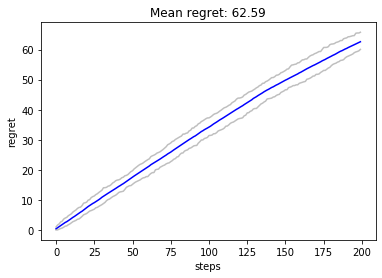

In [14]:
plt.plot(cum_regret.mean(axis=0), color='blue')
plt.plot(np.quantile(cum_regret, 0.05,axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(cum_regret, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()